# LLM Information Extraction Evaluation
## Status: Experimental
    
This notebook attempts to provide a systematic approach for model evaluation, startig from a given business problem.


Evaluating LLMs is a complex task. While there are benchmarks (e.g. https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard or https://crfm.stanford.edu/helm/latest/)
 available that provide a general view of how a particular LLM would perform in some common NLP tasks, most of evaluation frameworks/approaches are still evolving and none of them cover all aspects. It is important to understand which benchmark is the most relevant to a given use case, and to be mindful of the social aspects as well, and ultimately to evaluate LLMs against the data of your specific use case.
    
Business problem: 
Let's assume a financial analyst wants to use financial statements (balance sheets, income statements, operational reports, annual reports) to better understand the financial strength of a company to help assess risk and guide future investment decisisions.

To do this efficiently they need to extract information from these documents which consist largely of unstructured text.
This notebook focuses on Amazon's annual report, but the this approach can easily be adopted to other documents and an entire corpus of documents.

# Options
There are various options for you to choose from in this process:

- 1) Embeddings: Currently we are using amazon.titan-embed-text-v1, but will switch to amazon.titan-e1t-medium once generally available. 
- 2) Text Splitter: We used TokenTextSplitter from langchain. Other supported options within langchain are CharacterTextSplitter, RecursiveCharacterTextSplitter, or RecursiveCharacterTextSplitter. Which Splitter works best will vary based on your use case and source data types. In addition there are other libraries like unstructured or eparse available that can further improve retrieval relevance.
- 3) Vector Store: We used OpenSearch Serverless as our vector database to store embeddings. And while there are many vector databases available, you typically don't need a dedicated vector database, rather you can leverage a database that already hosts your data and supports vetor search such as PG Vector with RDS or OpenSearch. Data gravity is definitely a strong decision factor.  
- 4) Retrievers: OpenSearch VectoreStoreRetriver using KNN for similarity search. In general to retrieve text, there are two search types: “similarity” or “mmr”. search_type="similarity" uses similarity search and the retriever object where it selects text chunk vectors that are most similar to the question vector. search_type="mmr" uses the maximum marginal relevance search where it optimizes for similarity to query AND diversity among selected documents.
- 5) Chain Type: The default chain_type="stuff" uses ALL of the text from the documents in the prompt. This might work fine for information extraction within one document, but will not work for information extraction from very large documents or a large corpus of documents. This is where the "map_reduce" chain type comes in. map_reduce separates texts into batches and feeds each batch with the question to the LLM separately, and comes up with the final answer based on the answers from each batch. In contrast the "refine" chain type separates texts into batches, feeds the first batch to LLM, and feeds the answer and the second batch to LLM. It refines the answer by going through all the batches. And lastly, "map-rerank"  separates texts into batches, feeds each batch to LLM, returns a score of how fully it answers the question, and comes up with the final answer based on the high-scored answers from each batch.
- 6) Prompt Template: In addition to the model parameter size, model type (instruct, chat, light, instant, hf), precision (fp32, fp16), and quantization itself and the options referenced above, there are other variables that impact the response of an LLM, including:
Model parameters: Maximum tokens, temperature, top-p, top-k, and frequency penalty
User prompt: Changing even a single word or punctuation may result in vastly different responses
Prompt template: Determines tone, tenor, pace, mood, voice, syntax, diction, format, and length of response and helps enforce the use of the supplied contextual reference


TO DO: Add guidance/documentation for PromptTemplate - Dan - open

In [ ]:
# install dependencies
%pip uninstall awscli boto3 botocore langchain  -y

%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

%pip install --quiet langchain==0.0.309 --force-reinstall
%pip install langsmith tiktoken nltk python-dotenv xmltodict requests-aws4auth pypdf opensearch-py

In [98]:
# restart kernel to ensure proper version of libraries is loaded
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()

In [99]:
!pip list | grep -E "awscli|boto3|botocore|langchain"

awscli                               1.29.57
boto3                                1.28.57
botocore                             1.31.57
langchain                            0.0.305


In [101]:
# load environment variables 
import boto3
import os
import botocore
from botocore.config import Config
import langchain
import sagemaker
import pandas as pd

from langchain.llms.bedrock import Bedrock
from langchain.llms import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from typing import Dict

import json
import requests
import csv
import time
import pandas as pd
import nltk
import sys

from langchain.llms import Bedrock
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv('dev.env'),override=True)

session = sagemaker.Session()
bucket = session.default_bucket()

os.environ['LANGCHAIN_ASSUME_ROLE'] = os.getenv('LANGCHAIN_ASSUME_ROLE')
os.environ['BEDROCK_REGION_NAME'] = os.getenv('BEDROCK_REGION_NAME') # 'us-west-2'
os.environ['BEDROCK_ENDPOINT_URL'] = os.getenv('BEDROCK_ENDPOINT_URL') # 'https://prod.us-west-2.frontend.bedrock.aws.dev'
os.environ['OPENSEARCH_COLLECTION'] = os.getenv('OPENSEARCH_COLLECTION')
os.environ['OPENSEARCH_REGION'] = os.getenv('OPENSEARCH_REGION')

# Initialize Bedrock runtime
config = Config(
   retries = {
      'max_attempts': 8
   }
)
bedrock_runtime = boto3.client(
        service_name="bedrock-runtime",
        region_name=os.environ.get("BEDROCK_REGION_NAME", None),
        config=config
)

# Initialize the DynamoDB client
dynamodb_client = boto3.client('dynamodb')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide1.jpeg" alt="LLM selection process" width="900" height="550">

# 1) Quick short listing
Based on the LLM capabilties select a dozen models for a small test 

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide2.jpeg" alt="LLM capabilities" width="900" height="550">

TO DO: Add guidance/documentation on why we selected the below 3 LLMs for this use case - Harsha - open

In [102]:
## 1a. Initialize llm01 = Claude-v2
inference_modifier = {
    "max_tokens_to_sample": 545,
    "temperature": 0,
    "stop_sequences": ["\n\nHuman"],
}

llm01 = Bedrock( #create a Bedrock llm client
    region_name=os.environ.get("BEDROCK_REGION_NAME"), #sets the region name (if not the default)
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL"), #sets the endpoint URL (if necessary)
    model_id="anthropic.claude-v2",
    model_kwargs=inference_modifier
)

In [103]:
## 1b. Initialize Cohere Command
## below is not available yet in langchain, therefore we are creating a custom LLM wrapper

#llm02 = Bedrock( #create a Bedrock llm client
#    region_name=os.environ.get("BEDROCK_REGION_NAME"),
#    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL"),
#    model_id="cohere.command-text-v14",
#)

from typing import Any, List, Mapping, Optional
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM

class CohereLLM(LLM):
    max_tokens: int
    temperature: int
    
    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        """Get the identifying parameters."""
        return {"max_tokens": self.max_tokens,"temperature": self.temperature}
    
    @property
    def _llm_type(self) -> str:
        return "cohere.command-text-v14"

    def _call(
        self,
        prompt: str,
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> str:
        if stop is not None:
            raise ValueError("stop kwargs are not permitted.")
            
        
        modelId = 'cohere.command-text-v14' # change this to use a different version from the model provider

        accept = '*/*'
        contentType = 'application/json'
        prompt_data = f"""Human: {prompt}
                         Assistant: 
                      """

        model_kwargs = {
                        "max_tokens": self.max_tokens,
                        "temperature": self.temperature,

                       }
        model_kwargs["prompt"] = prompt_data
        body = json.dumps(model_kwargs)
        response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
        response_body = json.loads(response.get('body').read())
        try:
            result = response_body['generations'][0]['text'].strip()
        except:
            result = ''
        return result


llm02 = CohereLLM(max_tokens=545,temperature=0)

In [104]:
## 1c. Initialize SageMaker model - Llama-7B
class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
        input_str = json.dumps({
            "inputs": [[
                {"role": "user", "content": prompt},
            ]],
            "parameters": {"max_new_tokens": model_kwargs['max_new_tokens'], "top_p": model_kwargs['top_p'], "temperature": model_kwargs['temperature']}
        })
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        response_json = response_json[0]['generation']['content']
        
        return response_json

content_handler = ContentHandler()

llm03=SagemakerEndpoint(
     endpoint_name="jumpstart-dft-meta-textgeneration-llama-2-7b-f", 
     region_name="us-east-1",
     model_kwargs={"max_new_tokens": 545, "top_p": 0.9, "temperature": 0},
     endpoint_kwargs={"CustomAttributes": 'accept_eula=true'},
     content_handler=content_handler
 )

In [105]:
# 1d. Start with a simple example - no prompt template or RAG, just passing the prompts below directly into the LLMs
from langchain import LLMChain, HuggingFaceHub, Prompt
from langchain.model_laboratory import ModelLaboratory

llms = [
    llm01,
    llm02,
    llm03
]

test_prompts = [ "What are the three main business units of the company?",
    "What were the company's key areas of investment?",
    "What is the single most important risk the company faces in the next year?"]

model_lab = ModelLaboratory.from_llms(llms)

for question in test_prompts:
    prompt = f"""
    Amazon operates three main business segments: North America retail sales, International retail sales, and Amazon Web Services ("AWS"). 

    Risk Factors:
    - Intense competition globally in all business areas - Amazon competes with various companies including physical retailers, e-commerce companies, technology companies, device makers, digital content creators, delivery/logistics providers, and more. 
    - International expansion brings regulatory, infrastructure, and operational risks. Amazon must comply with complex regulations abroad and faces limitations related to infrastructure, local business practices, laws, and legal liability.
    - Demand fluctuation strains operations. Amazon's business sees seasonal sales spikes that test fulfillment capacity. Failure to meet demand can significantly impact sales.
    - Reliance on sellers exposes Amazon to fraud risk. Amazon could face liability for seller violations of policies or fraud. 
    - Protecting IP is challenging. Amazon relies on IP protections globally but enforcement is difficult. Others claim Amazon infringes their IP rights through litigation. 
    - Foreign exchange fluctuations impact results. Amazon has extensive international operations and holds foreign cash, so currency changes affect financials.
    - Rapid expansion strains resources. Adding employees, products/services and infrastructure complexity taxes Amazon's resources. 
    - Accounting requires estimates. Financial reporting relies on certain estimates that may prove incorrect over time.
    - Competitive hiring is critical. Amazon needs to attract and retain technical and executive talent in a tight labor market.
    - Acquisition integration is difficult. Adding companies brings risks during integration and may not meet financial expectations.
    - Security threats bring business risk. Amazon faces cyber attacks and threats requiring ongoing security investments.
    - Lawsuits and claims may arise. Amazon faces litigation, investigations, and other claims that could result in damages.

    Key areas of investment: devices, digital content, international physical/digital retail expansion, AWS growth, advertising, supply chain, and emerging areas like autonomous vehicles.

    Given the above information, answer the following question:
    """ + question
    
    model_lab.compare(prompt)

Input:

    Amazon operates three main business segments: North America retail sales, International retail sales, and Amazon Web Services ("AWS"). 

    Risk Factors:
    - Intense competition globally in all business areas - Amazon competes with various companies including physical retailers, e-commerce companies, technology companies, device makers, digital content creators, delivery/logistics providers, and more. 
    - International expansion brings regulatory, infrastructure, and operational risks. Amazon must comply with complex regulations abroad and faces limitations related to infrastructure, local business practices, laws, and legal liability.
    - Demand fluctuation strains operations. Amazon's business sees seasonal sales spikes that test fulfillment capacity. Failure to meet demand can significantly impact sales.
    - Reliance on sellers exposes Amazon to fraud risk. Amazon could face liability for seller violations of policies or fraud. 
    - Protecting IP is challengi

# 2) use case specific benchmark

Now after quickly testing the shortlisted LLMs, let's take the top 3 LLMs based on our initial results and LLM capabilities and perform a use case specific benchmark.

In our scenario the top 3 LLMs are Llama 2 13B, Cohere Command, and Anthropic Claude V2.

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide7.jpeg" alt="GeneratePrompts" width="900" height="550">

For our use case we happen to have labeled ground truth data which we can use for our test. Thus we can leverage classic ML-metrics to evaluate the performance of the different LLM pipelines.

In [124]:
## 2c. download ground truth dataset and insert into dynamodb table promptcatalog with columns prompt, context, output, evalationmetric, created_at,created_by
import xmltodict
url = 'https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluationdata/qsdata_200.xml'

# Send an HTTP GET request to download the file
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:        
    xml_data = xmltodict.parse(response.text)

# Convert the dictionary to a Pandas DataFrame
qa_dataset = pd.DataFrame(xml_data['root']['row'])

#show dataframe columns
print(qa_dataset.columns)

table_name = 'promptcatalog'
prompts = []
for row in qa_dataset.itertuples():
    item = {
        'prompt': str(row.question),
        'context': 'amazon_10k_2023.pdf',
        'output': str(row.answer),
        'evaluationmetric': 'Accuracy'
    }
    prompts.append(item)

save_prompts_to_dynamodb_table(table_name, prompts)

Index(['question', 'answer'], dtype='object')


If you do not have a ground truth dataset, then you can generate one with the help of a LLM as shown in the following example notebook:  https://github.com/fhuthmacher/NotebookExamples/blob/main/GenerateQuestionsAndAnswers.ipynb

In [107]:
## 2d. download context / Amazon annual report
import numpy as np
import pypdf
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from urllib.request import urlretrieve

os.makedirs("data", exist_ok=True)
files = [ "https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluationdata/amazon_10k_2023.pdf"]
for url in files:
    file_path = os.path.join("data", url.rpartition("/")[2])
    urlretrieve(url, file_path)
    

loader = PyPDFDirectoryLoader("./data/")
documents = loader.load()

In [108]:
## 2e. Split documents into smaller chunks 
### Compare results/impact of Character split and TokenTextSplitter

token_text_splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=100)
char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

token_text_list = token_text_splitter.split_documents(documents)
char_text_list = char_text_splitter.split_documents(documents)
    
print("TokenTextSplitter split documents in to " + str(len(token_text_list)) + " chunks.\n")
print("CharacterTextSplitter split documents in to " + str(len(char_text_list)) + " chunks.\n")

TokenTextSplitter split documents in to 189 chunks.

CharacterTextSplitter split documents in to 682 chunks.



In [109]:
## 2f. create vectors and store them in our vector database (OpenSearch Serverless)
### Connect to OpenSearchServerless
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

host = os.environ['OPENSEARCH_COLLECTION']  # serverless collection endpoint, without https://
region = os.environ['OPENSEARCH_REGION']  # e.g. us-east-1

service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

aos_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)

In [57]:
### Create a index in Amazon Opensearch Service 

# langchain version
knn_index = {
    "settings": {
        "index.knn": True,
        
    },
    "mappings": {
        "properties": {
            "vector_field": {
                "type": "knn_vector",
                "dimension": 1536,
                "store": True
            },
            "text": {
                "type": "text",
                "store": True
            },
        }
    }
}

index_name = "llmevaluation"
try:
    aos_client.indices.delete(index=index_name)
    print("Recreating index '" + index_name + "' on OpenSearch.")
    aos_client.indices.create(index=index_name,body=knn_index,ignore=400)
    aos_client.indices.get(index=index_name)
except:
    print("Index '" + index_name + "' not found. Creating index on OpenSearch.")
    aos_client.indices.create(index=index_name,body=knn_index,ignore=400)
    aos_client.indices.get(index=index_name)

Recreating index 'llmevaluation' on OpenSearch.


In [110]:
### Use Titan Embeddings Model to generate embeddings

from langchain.embeddings import BedrockEmbeddings
from langchain.llms.bedrock import Bedrock

# LangChain requires AWS4Auth
from requests_aws4auth import AWS4Auth
def get_aws4_auth():
    region = os.environ.get("Region", os.environ["AWS_REGION"])
    service = "aoss"
    credentials = boto3.Session().get_credentials()
    return AWS4Auth(
        credentials.access_key,
        credentials.secret_key,
        region,
        service,
        session_token=credentials.token,
    )
aws4_auth = get_aws4_auth()

bedrock_embeddings = BedrockEmbeddings(client=bedrock_runtime)


In [91]:
## Insert embeddings into OpenSearch
### For Serverless, please note is_aoss=True setting

from langchain.vectorstores import OpenSearchVectorSearch

full_opensearch_endpoint = 'https://' + os.environ['OPENSEARCH_COLLECTION']
    
# get embeddings and do insert to OpenSearch. Note: max 500 docs.
def opensearch_insert(source_doc_list, target_index_name):
    doc_search=OpenSearchVectorSearch.from_documents(
            index_name = target_index_name,
            documents=source_doc_list,
            embedding=bedrock_embeddings,
            opensearch_url=full_opensearch_endpoint,
            http_auth=auth,
            use_ssl=True,
            verify_certs=True,
            connection_class=RequestsHttpConnection,
            timeout=60*3,
            bulk_size=1000,
            is_aoss=True
        )
    inserted_doc_length = len(source_doc_list)
    input_doclist_name = f'{char_text_list=}'.split('=')[0]
    print(f'ingested {inserted_doc_length} documents from source {input_doclist_name} to target {target_index_name}')
    return doc_search

doc_search=opensearch_insert(source_doc_list=token_text_list, target_index_name=index_name)

ingested 189 documents from source char_text_list to target llmevaluation


In [111]:
### validate load
res = aos_client.search(index=index_name, body={"query": {"match_all": {}}})
print("Records found: %d." % res['hits']['total']['value'])

Records found: 189.


In [112]:
## 2e. Run prompts, and save responses & accuracy

from langchain.prompts import PromptTemplate

prompt_template = """
        Human: Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

prompt_template_two = """
Human: 
You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.

Assistant:
Understood. I will provide information based on the context given, without relying on prior knowledge.

Human:
If you don't see answer in the context just reply "not available" in XML tags.

Assistant:
Noted. I will respond with "not available" if the information is not available in the context.

Human:
Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
{context}

Assistant:
Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
{question}
"""
PROMPT = PromptTemplate(
    template=prompt_template_two, input_variables=["question", "context"]
)

## test query
#query = "Who is the CEO of Amazon?"
#qa.run(query)

In [ ]:
# TO DO: 
## add different prompt templates and refactor evaluation pipeline to run for all llms

In [ ]:
### run all LLMs through qa catalog

from langchain.chains import RetrievalQA

promptsdf = pd.DataFrame(prompts)

predictions = []
for llm in llms:
    for row in promptsdf.itertuples():
        query = row.prompt
        qa = RetrievalQA.from_chain_type(
                llm=llm,
                chain_type="stuff",
                retriever=doc_search.as_retriever(),
                chain_type_kwargs = {"prompt": PROMPT}
            )
        result = qa.run(query)
        
        llm_name = ''
        try:
            llm_name = str(llm.model_id)
        except:
            try:
                llm_name = str(llm.endpoint_name)
            except:
                try:
                    llm_name = str(llm._llm_type)
                except:
                    pass
            
        predictions.append({
                "query": row.prompt,
                "llm": str(llm_name),
                "context": 'amazon_10k_2023.pdf',
                "output": str(result),
                "trainingoutput": str(row.output),
                "evaluationmetric": "",
                "score": "",
                "feedback": ""
        })

In [135]:
### 3a. LLM evaluation using StringEvaluator
from typing import Optional
from langsmith.evaluation import StringEvaluator

def jaccard_chars(output: str, answer: str) -> float:
    try:
        """Naive Jaccard similarity between two strings."""
        prediction_chars = set(output.strip().lower())
        answer_chars = set(answer.strip().lower())
        intersection = prediction_chars.intersection(answer_chars)
        union = prediction_chars.union(answer_chars)
        return len(intersection) / len(union)
    except:
        return 1
 
def grader(run_input: str, run_output: str, answer: Optional[str]) -> dict:
    """Compute the score and/or label for this run."""
    if answer is None:
        value = "AMBIGUOUS"
        score = 0.5
    else:
        score = jaccard_chars(run_output, answer)
        value = "CORRECT" if score > 0.9 else "INCORRECT"
    return dict(score=score, value=value)
            
string_eval_predictions = []
for prediction in predictions:
        evaluation_result = grader(prediction['query'], prediction['output'], prediction['trainingoutput'])    
        string_eval_predictions.append({
                "query": prediction['query'],
                "llm": prediction['llm'],
                "context": 'amazon_10k_2023.pdf',
                "output": prediction['output'],
                "trainingoutput": prediction['trainingoutput'],
                "evaluationmetric": "Naive Jaccard similarity between two strings",
                "score": str(evaluation_result['value']),
                "feedback": "similarity score= " + str(evaluation_result['score']),
            })

In [156]:
### 3b. LLM evaluation using a mechanism for LLM-assisted evaluation to compare and score the responses 
### with the help of LLMs using langchain QAEvalChain

from langchain.chat_models import BedrockChat
from langchain.evaluation.qa import QAEvalChain
import time
inference_modifier = {
    "max_tokens_to_sample": 545,
    "temperature": 0,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman"],
}

llm = BedrockChat(model_id="anthropic.claude-v2", model_kwargs=inference_modifier)

eval_chain = QAEvalChain.from_llm(llm)

qa_list = [{'query': item['query'], 'answer': item['trainingoutput']} for item in predictions]

## to avoid read timeouts split qa_list into 50 records chunks 
## and execute eval_chain_evaluate function for each chunk with a wait period in betwwen
chunk_size = 50
graded_outputs = []
qa_chunks = [qa_list[i:i + chunk_size] for i in range(0, len(qa_list), chunk_size)]
qa_predictions = [predictions[i:i + chunk_size] for i in range(0, len(predictions), chunk_size)]

i = 0
print(f'Total # of chunks {len(qa_chunks)}')
while i < len(qa_chunks):
    print(f'starting chunk {i}')
    try:
        graded_output_chunk = eval_chain.evaluate(qa_chunks[i], qa_predictions[i], question_key = 'query', prediction_key = 'output')
        graded_outputs.append(graded_output_chunk)
        # wait between each chunk
        time.sleep(60)
    except:
        print('going to next chunk')
        continue
    i+=1
    
# graded_outputs = eval_chain.evaluate(qa_list, predictions, question_key = 'query', prediction_key = 'output')

Total # of chunks 10
starting chunk 0
starting chunk 1
starting chunk 2
starting chunk 3
starting chunk 4
starting chunk 5
starting chunk 6
starting chunk 7
starting chunk 8
starting chunk 9


In [163]:
### 3c. Store LLM evaluated metrics in llmevaluationresults table
llm_eval_predictions=[]
graded_outputs_flat = [item for sublist in graded_outputs for item in sublist]

for i, eg in enumerate(graded_outputs_flat):
    grade = ''
    try:
        if 'GRADE: INCORRECT' in str(graded_outputs_flat[i]['results']):
            grade = 'INCORRECT'
        else:
            grade = 'CORRECT'  
    except:
        print('failed to extract grade')

    llm_eval_predictions.append({
                "query": predictions[i]['query'],
                "llm": predictions[i]['llm'],
                "context": predictions[i]['context'],
                "output": predictions[i]['output'],
                "trainingoutput": predictions[i]['trainingoutput'],
                "evaluationmetric": "LLM-assisted evaluation with Claude",
                "score": grade,
                "feedback": str(graded_outputs_flat[i]['results'])
            })

LLM-assisted evaluation provides significant better evaluation results compared to string evaluation. Yet it does not require insights into Faithfulness, Context Precision,Context Recall, Answer Relevancy,or Aspect Critiques), which would be helpful for a RAG use case like this. This is where libraries like ragas-langsmith can be helpful (requires an OpenAI API key).

<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide8.jpeg" alt="EvaluatingResults" width="900" height="550">

In [229]:
### 3d. evaluating overall model accuracy

# Count the number of CORRECT and INCORRECT evaluations for each LLM and evaluation method
llm_eval_predictions_df = pd.DataFrame(llm_eval_predictions)

# get value of grouby column
llm_eval_predictions_df['llm'] = llm_eval_predictions_df['llm'].str.strip()
llm_eval_predictions_df['CORRECT_Count'] = llm_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'CORRECT').sum())
llm_eval_predictions_df['INCORRECT_Count'] = llm_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'INCORRECT').sum())
llm_eval_predictions_df['llm_eval_accuracy'] = llm_eval_predictions_df['CORRECT_Count'] / (llm_eval_predictions_df['CORRECT_Count'] + llm_eval_predictions_df['INCORRECT_Count'])
llm_eval_predictions_df['TOTAL_Count'] = llm_eval_predictions_df['CORRECT_Count'] + llm_eval_predictions_df['INCORRECT_Count']

# remove all columns from dataframe except columns TOTAL_Count, CORRECT_Count, INCORRECT_Count, llm_eval_accuracy
llm_eval_predictions_df = llm_eval_predictions_df[['llm','TOTAL_Count', 'CORRECT_Count', 'INCORRECT_Count', 'llm_eval_accuracy']]

#remove all duplicate rows from llm_eval_predictions_df
llm_eval_predictions_df = llm_eval_predictions_df.drop_duplicates()

# Count the number of CORRECT and INCORRECT evaluations for each LLM and evaluation method
string_eval_predictions_df = pd.DataFrame(string_eval_predictions)

# get value of grouby column
string_eval_predictions_df['llm'] = string_eval_predictions_df['llm'].str.strip()
string_eval_predictions_df['CORRECT_Count'] = string_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'CORRECT').sum())
string_eval_predictions_df['INCORRECT_Count'] = string_eval_predictions_df.groupby('llm')['score'].transform(lambda x: (x == 'INCORRECT').sum())
string_eval_predictions_df['llm_eval_accuracy'] = string_eval_predictions_df['CORRECT_Count'] / (string_eval_predictions_df['CORRECT_Count'] + string_eval_predictions_df['INCORRECT_Count'])
string_eval_predictions_df['TOTAL_Count'] = string_eval_predictions_df['CORRECT_Count'] + string_eval_predictions_df['INCORRECT_Count']

# remove all columns from dataframe except columns TOTAL_Count, CORRECT_Count, INCORRECT_Count, llm_eval_accuracy
string_eval_predictions_df = string_eval_predictions_df[['llm','TOTAL_Count', 'CORRECT_Count', 'INCORRECT_Count', 'llm_eval_accuracy']]

#remove all duplicate rows from llm_eval_predictions_df
string_eval_predictions_df = string_eval_predictions_df.drop_duplicates()

# show first 4 rows from llm_eval_predictions_df
string_eval_predictions_df.head(4)

# show first 4 rows from llm_eval_predictions_df
#llm_eval_predictions_df.head(4)

,llm,TOTAL_Count,CORRECT_Count,INCORRECT_Count,llm_eval_accuracy
0,anthropic.claude-v2,196,14,182,0.071429
196,cohere.command-text-v14,196,18,178,0.091837
392,jumpstart-dft-meta-textgeneration-llama-2-7b-f,79,1,78,0.012658


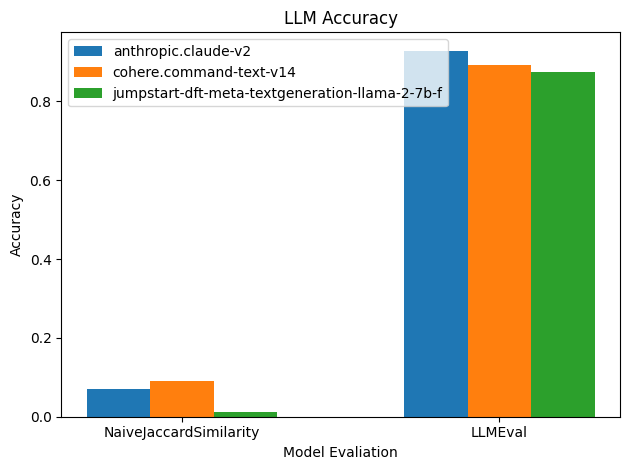

In [258]:
### 3e. visualize model accuracy
# plot each row' accuracy column in overall_accuracy with matplotlib


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

categories = ["NaiveJaccardSimilarity", "LLMEval"]
dataprep = []
for index, row in llm_eval_predictions_df.iterrows():
    llm_name = row['llm']
    result_df = string_eval_predictions_df[string_eval_predictions_df['llm'] == llm_name]
    value = result_df.loc[index, 'llm_eval_accuracy']
    dataprep.append([llm_name, pd.to_numeric(value), pd.to_numeric(row['llm_eval_accuracy'])])

data = {
    'EvaluationMethod': ["NaiveJaccardSimilarity", "LLMEval"],
    dataprep[0][0] : dataprep[0][1:],
    dataprep[1][0]: dataprep[1][1:],
    dataprep[2][0]: dataprep[2][1:]
}

df = pd.DataFrame(data)

# Set the width of the bars and the number of series
num_series = len(df.columns) - 1  # Subtract 1 to exclude the 'Category' column
bar_width = 0.2
bar_positions = np.arange(len(df))

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each series
for i, col in enumerate(df.columns[1:]):
    offset = (i - (num_series - 1) / 2) * bar_width
    ax.bar(bar_positions + offset, df[col], width=bar_width, label=col)

# Set x-axis labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(df['EvaluationMethod'])

# Labeling and legend
ax.set_xlabel('Model Evaliation')
ax.set_ylabel('Accuracy')
ax.set_title('LLM Accuracy')
ax.legend()

# Show the chart
plt.tight_layout()  # Optional: Adjust layout for better spacing
plt.show()


<img src="https://d3q8adh3y5sxpk.cloudfront.net/meetingrecordings/modelevaluation/Slide9.jpeg" alt="EvaluatingResults" width="900" height="550">

TO DO: Add guidance/documentation (along the lines of cost,performance, accuracy) - Harsha - open

# What can be improved in the evaluation strategy?
- Use other metrics than accuracy. Maybe a semantic similarity metric like the one proposed in "Semantic Answer Similarity for Evaluating Question Answering Models" (arXiv:2108.06130).

- Evaluate each component of the system (see options above) in isolation. For example evaluate the retrieval system/strategy separately and not just the entire pipeline as a whole. You could evaluate the retrieval system by saving the chunks that were used/are relevant for the actual answer alongside with the questions and answers in the evaluation dataset. Then you can compare/evaluate which top k chunks are being selected during the evaluation and whether or not the retriever selected a chunk with the source truth and at which rank and experiment with the different retriever options and chain types.

- Explore parsers/tools in conjunction with LLMs, e.g. eparse (https://github.com/ChrisPappalardo/eparse), unstructured (https://github.com/Unstructured-IO/unstructured), and/or Kor (https://eyurtsev.github.io/kor/tutorial.html)

- Incorporate other dimensions such as performance/latency and cost in more detail into the evaluation as well to derive at a cost performance benchmark

# Conclusion
- LLMs are here to stay, and the evaluation of LLMs is still evolving, with new research and tooling being released on a regular basis.
- While this notebook focused on LLM accuracy, it also highlights the importance of other dimesions such as cost and latency, and outlines a practical approach to model evaluation.

### SCRATCH

In [13]:
### alternative version without langchain for creating embeddings

def get_embedding(body, modelId, accept, contentType):
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

def embed_phrase(phrase):
    body = json.dumps({"inputText": str(phrase)})
    modelId = 'amazon.titan-embed-text-v1' #'amazon.titan-e1t-medium' # not available yet
    contentType = 'application/json'
    accept = 'application/json'
    embedding = get_embedding(body, modelId, accept, contentType)
    return embedding
    
def os_import(record, aos_client, index_name):
    search_vector = embed_phrase(record)
    aos_client.index(index=index_name,
             body={"vector_field": search_vector,
                   "text": record
                  },
            request_timeout=60*3,  # 3 minutes
            )

def query_opensearch(index_name, phrase, n=1):
    search_vector = embed_phrase(phrase)
    osquery={
        "_source": {
            "exclude": [ "vector_field" ]
        },
        
      "size": n,
      "query": {
        "knn": {
          "vector_field": {
            "vector":search_vector,
            "k":n
          }
        }
      }
    }

    res = aos_client.search(index=index_name, 
                           body=osquery,
                           stored_fields=["text"],
                           explain = True)
    print(res)
    result = {
            "text":""
        }
    if res['hits']['hits']:
        top_result = res['hits']['hits'][0]
    
        result = {
            "text":top_result['_source']['text'],

        }
    
    return result


### test embedding
#embed_phrase("pairs well with chocolate")

# test insert
# token_text_list
#for record in char_text_list: 
#    #print(record.page_content)
#    os_import(record.page_content, aos_client, index_name)

#for record in token_text_list: 
    #print(record.page_content)
#    os_import(record.page_content, aos_client, index_name)
    
#for record in token_text_list: 
#    print(record.page_content)

In [35]:
# SageMaker endpoint query

sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")
from sagemaker.predictor import Predictor

def query_endpoint(payload, endpoint_name):
    """Query endpoint and print the response"""

    response_model = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=payload,
        ContentType="application/json",
    )

    generated_text = response_model["Body"].read().decode("utf8")
    print(generated_text)


payload = json.dumps(
    {
        "inputs": "What is so special about Amazon?",
        "parameters": {"max_new_tokens": 126, "no_repeat_ngram_size": 3},
    }
)

endpoint_name = "lmi-model-falcon-7b-2023-08-27-17-52-54-260"
query_endpoint(payload, endpoint_name)

{"generated_text": " The A3 is a compact car that is a lot more than just a compact car. It's a compact car that is a lot more than just a compact car. It's a compact car that is a lot more than just a compact car. It's a compact car that is a lot more than just a compact car. It's a compact car that is a lot more than just a compact car. It's a compact car that is a lot more than just a compact car. It's a compact car that is a lot more than just a compact car. It's a compact car"}


In [28]:
# bedrock helper methods for langchain

def get_inference_parameters(model): #return a default set of parameters based on the model's provider
    bedrock_model_provider = model.split('.')[0] #grab the model provider from the first part of the model id
    
    if (bedrock_model_provider == 'anthropic'): #Anthropic model
        return { #anthropic
            "max_tokens_to_sample": 545,
            "temperature": 0, 
            "top_k": 250, 
            "top_p": 1, 
            "stop_sequences": ["\n\nHuman:"] 
           }
    
    elif (bedrock_model_provider == 'ai21'): #AI21
        return { #AI21
            "maxTokens": 545, 
            "temperature": 0, 
            "topP": 0.5, 
            "stopSequences": [], 
            "countPenalty": {"scale": 0 }, 
            "presencePenalty": {"scale": 0 }, 
            "frequencyPenalty": {"scale": 0 } 
           }

    elif (bedrock_model_provider == 'cohere'):
        
        return { 
            "max_tokens": 545, 
            "temperature": 0, 
            "return_likelihood": "GENERATION",
            "stop_sequences": ["\n\nHuman:"],
            
           }
    
    else: #Amazon
        #For the LangChain Bedrock implementation, these parameters will be added to the 
        #textGenerationConfig item that LangChain creates for us
        return { 
            "maxTokenCount": 545, 
            "stopSequences": [], 
            "temperature": 0, 
            "topP": 0.9 
        }

def get_text_response(model, input_content): #text-to-text client function
    
    model_kwargs = get_inference_parameters(model) #get the default parameters based on the selected model
    
    llm = Bedrock( #create a Bedrock llm client
        region_name=os.environ.get("BEDROCK_REGION_NAME"), #sets the region name (if not the default)
        endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL"), #sets the endpoint URL (if necessary)
        model_id=model, #use the requested model
        model_kwargs = model_kwargs
    )
    return llm.predict(input_content) #return a response to the prompt

In [ ]:
# invoke Bedrock models with langchain helper method
# cohere.command-text-v14
# amazon.titan-text-express-v1
# anthropic.claude-v2
start = time.time()
response = get_text_response("anthropic.claude-v2", "What is a donut?")
print(response)

end = time.time()
print(end - start)

In [32]:
# invoke Bedrock model
# cohere.command-text-v14
# amazon.titan-text-express-v1
# anthropic.claude-v2
import json
modelId = 'cohere.command-text-v14' # change this to use a different version from the model provider

accept = '*/*'
contentType = 'application/json'

prompt_data = """Human: What is a donut?
                 Assistant: 
              """

model_kwargs = {
                "max_tokens": 545,
                "temperature": 0,
                
               }
               
model_kwargs["prompt"] = prompt_data
body = json.dumps(model_kwargs)

response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())
print(response_body)
print(response_body.get('completion'))

{'generations': [{'id': '4c74edb9-bcd1-48f3-8370-a48896e7b9bb', 'text': ' A donut, or doughnut, is a small fried cake of sweetened dough. Donuts are usually ring-shaped, and typically have a hole in the center. Donuts are popular around the world and are enjoyed by many people. \n\nThere are many different types of donuts, including:\n\n- Cake donuts, which are made from a cake-like batter and are typically smaller and more dense than other types of donuts.\n- Yeast donuts, which are made from a yeast dough and are often larger and fluffier than cake donuts.\n- Filled donuts, which are donuts that are injected with a filling, such as jelly or cream.\n- Frosted donuts, which are donuts that are topped with a frosting, such as chocolate or vanilla.\n- Glazed donuts, which are donuts that are coated with a glaze, such as a sugar or honey glaze.\n\nDonuts are often served as a dessert or a snack, and are often accompanied by coffee or other beverages. They can be purchased from donut shops